# Idea
* Do a robust binary threshold
    * DONE: Otsu was deemed most suitable
* Pad image to be able to find edges "outside" paper
    * DONE: skimage.util.pad was exactly what is needed
* Identify four longest lines
    * DOING: My grasp for neither hough_lines nor probabilistic_hough_lines is robust enough to accomplish this
* Intersect four longest lines to find edges
* Transform paper to standard
* Identify possible handwritten digits
* Train robust classifier
    * Preprocessing pipeline: Skew and rotate handwritten images to get a robust classifier
* Classify identified digits

In [1]:
import os
import matplotlib.pyplot as plt

import skimage.io
import skimage.filters
import skimage.feature
import skimage.transform.hough_transform as ht

import numpy as np
import ipywidgets as widgets
from pylab import rcParams

In [2]:
rcParams['figure.figsize'] = 10, 20

In [3]:
images = []
for filename in os.listdir('img'):
    img = skimage.io.imread(os.path.join('img',filename),as_gray=True)
    if img is not None:
        images.append(img)

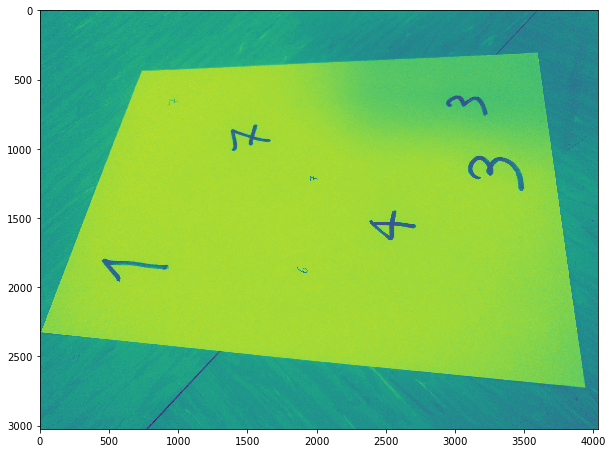

In [4]:
plt.imshow(images[0])

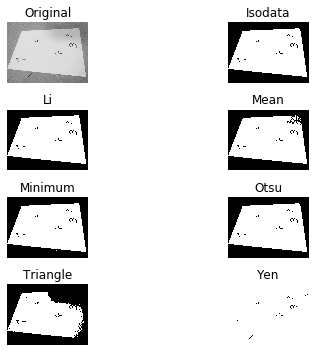

In [5]:
fig, ax = skimage.filters.try_all_threshold(images[0], verbose=False)
plt.show()

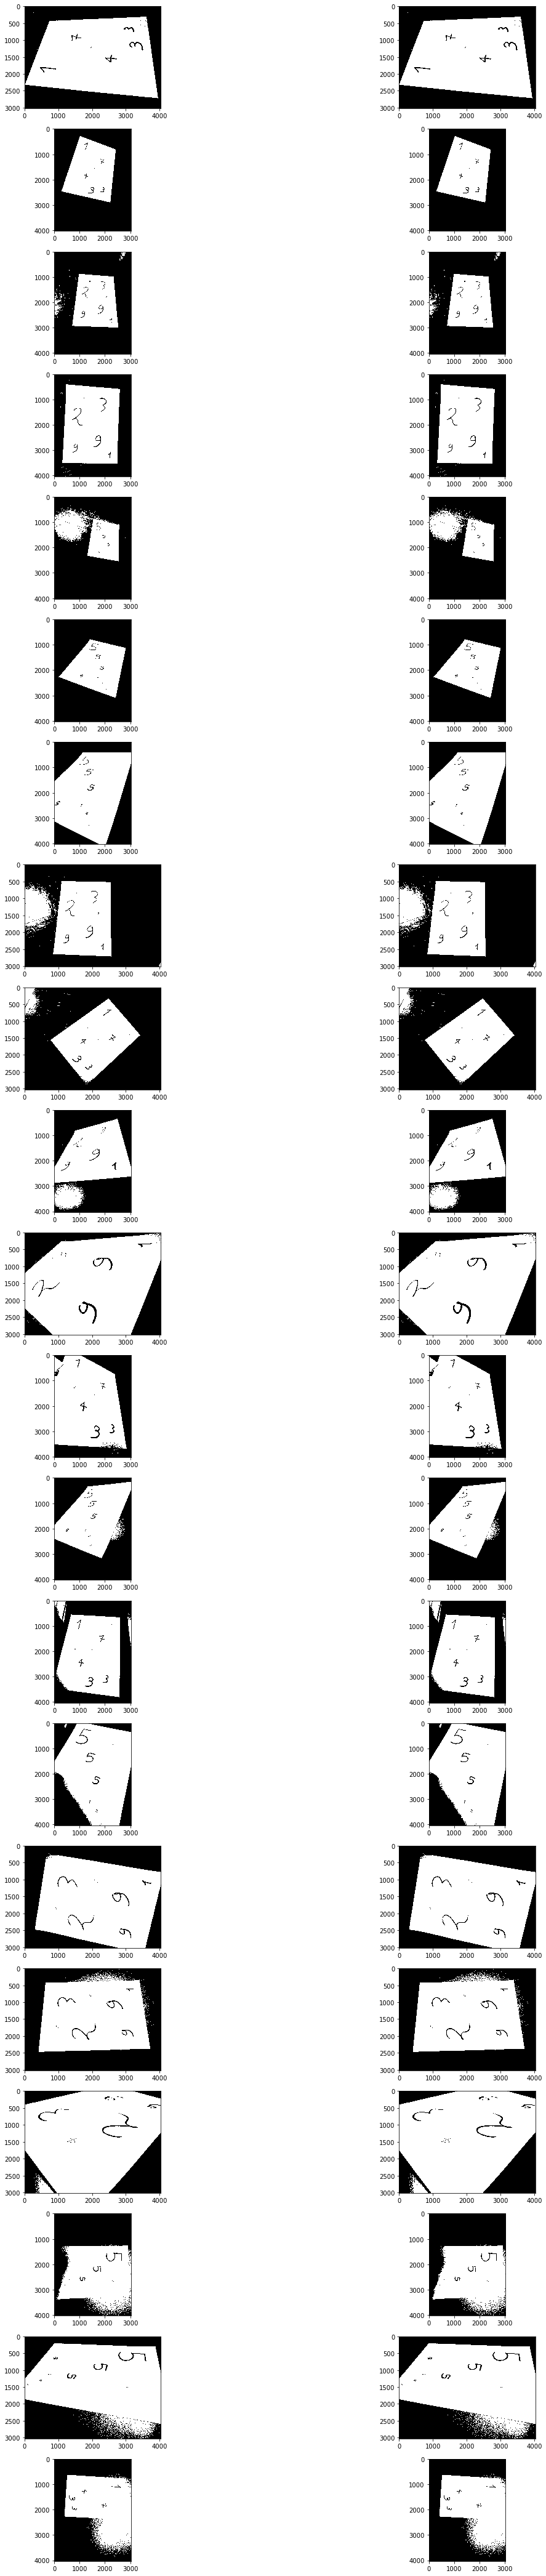

In [6]:
nrows = len(images) + 1
index = 1
f = plt.figure(figsize=(20,80))
for image in images:
    filtered_image = skimage.filters.threshold_isodata(image)
    f.add_subplot(nrows, 2, index)
    plt.imshow(image > filtered_image, cmap="gray")
    filtered_image = skimage.filters.threshold_otsu(image)
    f.add_subplot(nrows, 2, index+1)
    plt.imshow(image > filtered_image, cmap="gray")
    index += 2

In [7]:
binary_images = []
for image in images:
    filtered_image = skimage.filters.threshold_otsu(image)
    binary_images.append(image > filtered_image)

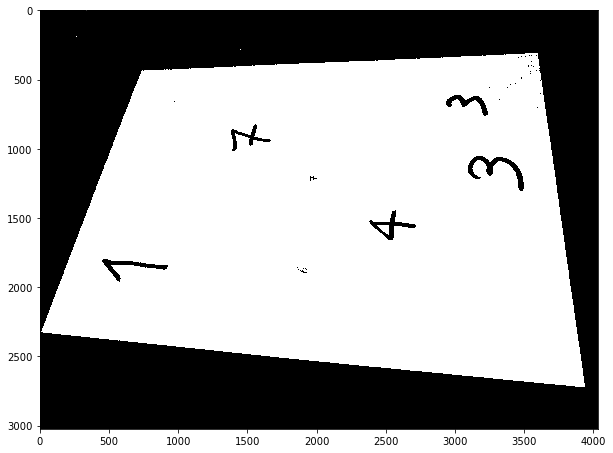

In [8]:
plt.imshow(binary_images[0],cmap='gray')

In [25]:
@widgets.interact(canny_sigma=(0,10), hough_threshold=(10,200,20))
def f(canny_sigma, hough_threshold):
    imedges = skimage.feature.canny(binary_images[0], sigma=canny_sigma)
    lines = ht.probabilistic_hough_line(imedges,
                                        threshold=hough_threshold,
                                        line_gap=100,
                                        line_length=300,
                                        seed=1337)
    fig,(ax0,ax1) = plt.subplots(ncols=2, figsize=(16,12))
    ax0.imshow(binary_images[0],cmap="gray")
    for ((x0,y0),(x1,y1)) in lines:
        ax0.plot([x0,x1],[y0,y1],'r-')
    ax1.imshow(imedges,cmap="gray")

interactive(children=(IntSlider(value=5, description='canny_sigma', max=10), IntSlider(value=90, description='…

In [11]:
images[0].shape

(3024, 4032)

In [12]:
max(images[0].shape)

4032

In [13]:
padded_images = []
for bimage in binary_images:
    padded_images.append(
        skimage.util.pad(
            bimage, int(np.round(max(bimage.shape)/2)), mode='constant', constant_values = 0
        )
    )

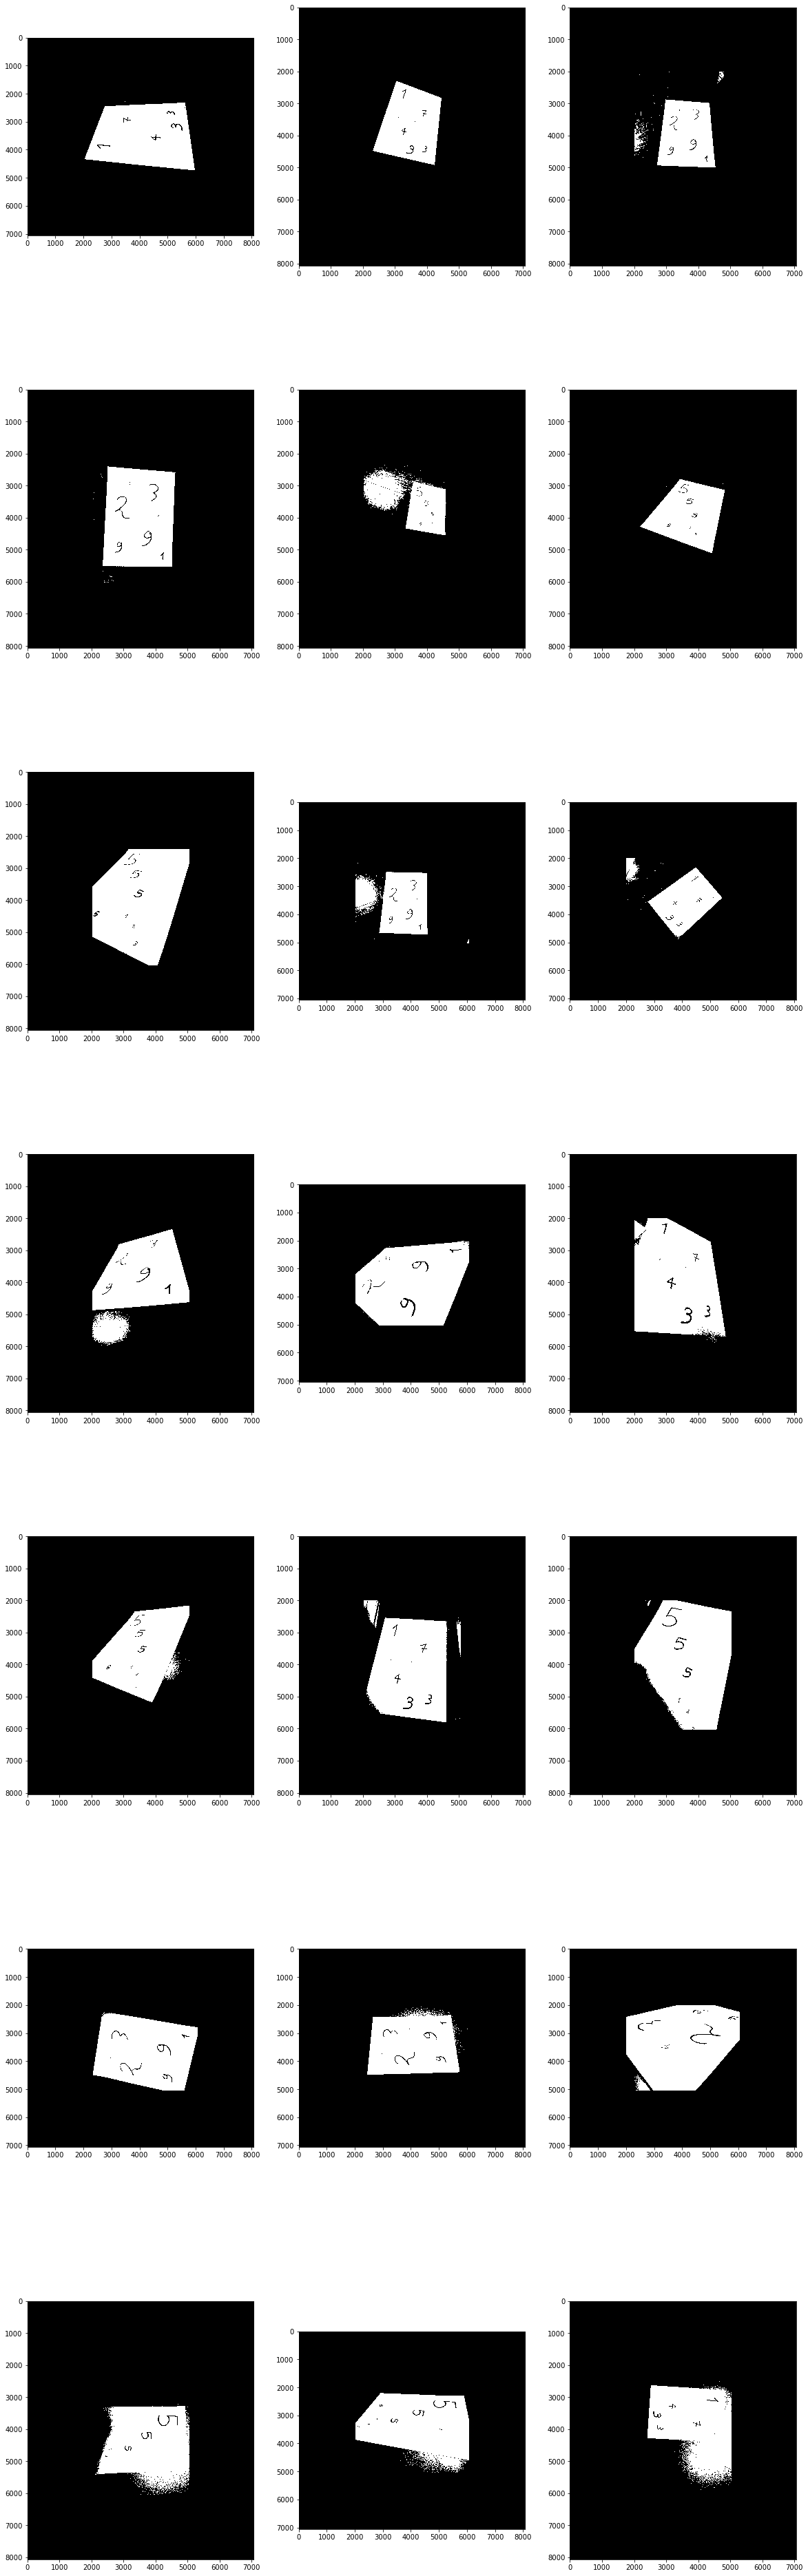

In [16]:
nrows = np.ceil((len(padded_images) + 1) / 3)
f = plt.figure(figsize=(20,80))
index = 1
for image in padded_images:
    f.add_subplot(nrows, 3, index)
    plt.imshow(image, cmap="gray")
    index += 1

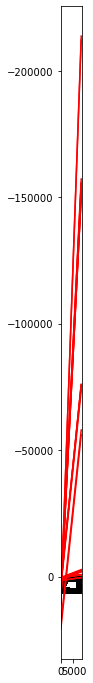

In [27]:
imedges = skimage.feature.canny(padded_images[0], sigma=10)
lines = ht.probabilistic_hough_line(imedges,
                                    threshold=110,
                                    line_gap=100,
                                    line_length=300,
                                    seed=1337)

fig,ax = plt.subplots(figsize=(16,12))
ax.imshow(padded_images[0],cmap="gray")
origin = np.array((0, padded_images[0].shape[1]))
for line in lines:
    x = np.abs(line[0][0] - line[1][0])
    y = np.abs(line[0][1] - line[1][1])
    dist = np.sqrt(x**2 + y**2)
    angle = np.arctan(np.abs(y/x))
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax.plot(origin, (y0,y1), '-r')